# DAY 8: Model Interpretation and data manipulation

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: August 3rd, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. encode non-numerical data
2. preprocess data: scaling covariates, outlier removal and data imputation
3. model interpretation for down-stream application

### Load necessary libraries

In [20]:
# as usual, let us load all the necessary libraries
import numpy as np  # numerical computation with arrays
import pandas as pd # library to manipulate datasets using dataframes
import scipy as sp  # statistical library

# below sklearn libraries for different models
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# plot 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [21]:
# function to generate random splits
def split_data(X, y ,seed=29):
    ''' Function to split  randomly your dataset in train and test '''
    N,D = X.shape
    test_size=0.4
    np.random.seed(seed)
    permuted_idxs = np.random.permutation(N)
    N_train = int(np.floor(N*(1-test_size)))
    train_idxs = permuted_idxs[:N_train]
    test_idxs = permuted_idxs[N_train:]
    X_train = X[train_idxs,:]
    X_test = X[test_idxs,:]
    y_train = y[train_idxs]
    y_test = y[test_idxs]
    return X_train, X_test, y_train, y_test

# function to print feature importances (size of coefficients)
def print_sorted_feat_importance(weights, colnames):
    feature_weights = pd.Series(weights, index=colnames)
    feature_weights_sorted = feature_weights.apply(np.abs).sort_values(ascending=False)

    for name in feature_weights_sorted.index:
         print('{:23s}: {:.4f}'.format(name, feature_weights[name]))
            
# function to plot confidence intervals
def plot_confidence_intervals(bootstrap_weights, ax):
    rows = bootstrap_weights.shape[0]
    columns = bootstrap_weights.shape[1]
    bootstrap_weights = bootstrap_weights.reshape((rows, columns))
    ax.set_title("Variation in weight across variations in train set")
    ax.boxplot(bootstrap_weights)
    ax.set_ylabel('Weight values')
    ax.set_xlabel('Features')
    ax.set_xticklabels(X_colnames, rotation=90)
    return ax

# function to plot predictive intervals
def plot_predictive_intervals(bootstrap_predictions, labels, ax):
    rows = bootstrap_predictions.shape[0]
    columns = bootstrap_predictions.shape[1]
    bootstrap_predictions = bootstrap_predictions.reshape((rows, columns))
    ax.set_title("Variation in prediction across variations in train set")
    ax.boxplot(bootstrap_predictions)
    ax.set_ylabel('Predicted Sales')
    ax.set_xlabel('Companies')
    ax.set_xticklabels(labels, rotation=90)
    return ax

def get_data(messy_data=True):

    # load the data using pandas
    X_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/Rwanda-course-2020/master/In-class/X.csv')
    y_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/Rwanda-course-2020/master/In-class/y.csv')

    # change $ to cents
    X_df['bus_stops ($)'] *= 100.0
    X_df.rename(columns={'bus_stops ($)': 'bus_stops (cents)'}, inplace=True)

    # add id
    X_df['company id number'] = np.arange(X_df.shape[0])

    # add country
    r = X_df['TV ($)']
    r += np.random.normal(scale=2.0, size=r.shape)
    X_df['Country'] = r
    X_df.loc[r < 25.0, 'Country'] = 'Mexico'
    X_df.loc[(r > 25.0) & (r < 160.0), 'Country'] = 'USA'
    X_df.loc[r > 160.0, 'Country'] = 'Rwanda'

    X_df['Nationality'] = r
    X_df.loc[r < 25.0, 'Nationality'] = 'Mexican'
    X_df.loc[(r > 25.0) & (r < 160.0), 'Nationality'] = 'American'
    X_df.loc[r > 160.0, 'Nationality'] = 'Rwandan'


    if messy_data:    
        # create outliers
        p_outliers = 0.1
        outlier_idx = X_df.sample(frac=p_outliers, replace=True).index
        X_outliers = X_df.iloc[outlier_idx].copy()
        X_outliers[['electricity (mega W)', 'water (10^3 m3)']] += 30.0
        X_df = pd.concat([X_df, X_outliers], ignore_index=True)
        y_df = pd.concat([y_df, y_df.iloc[outlier_idx]], ignore_index=True)

        # add missing values
        p_missing_per_columnn = 0.01
        for c in X_df.columns:
            missing_idx = X_df.sample(frac=p_missing_per_columnn, replace=False).index
            X_missing = X_df.iloc[missing_idx].copy()
            X_missing[c] = np.NaN

            X_df = pd.concat([X_df, X_missing], ignore_index=True)
            y_df = pd.concat([y_df, y_df.iloc[missing_idx]], ignore_index=True)

    new_index = np.random.permutation(X_df.index)
    X_df = X_df.reindex(new_index)
    y_df = y_df.reindex(new_index)

    return X_df, y_df

---

## Predicting total sales from marketing strategy

In this exercise, you are asked to build a machine learning model to predict the total sales of a company based on their marketing strategy (how much money they invest in advertisement and in which venues they choose to advertise) as well as a few additional features of the company.

The goal is not only to predict how much sales a company should expect, the goal is to also make a recommendation to the company on how they should adjust their marketing strategy or internal operations (e.g. you might recommend, based on your model, that the company invests more in social media marketing).

#### Load the dataset and examine it

In [22]:
# load the data using pandas
X_df, y_df = get_data()

In [23]:
# print the first rows of the marketing strategies data
X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Country,Nationality
88,0.455175,0.660908,4744.967315,7.755908,44.205268,85.521450,25.5,73.4,88.0,USA,American
55,1.115766,2.904203,4105.802018,46.483029,12.404447,197.839943,49.4,60.0,55.0,Rwanda,Rwandan
204,32.925667,30.105909,1693.784416,11.584022,1.858200,214.925369,24.0,4.0,11.0,Rwanda,Rwandan
140,1.713527,1.916915,2166.614332,32.110312,27.325866,70.176185,17.0,12.9,140.0,USA,American
178,0.050147,1.222481,3709.166436,14.215786,34.583611,275.229401,2.3,23.7,178.0,Rwanda,Rwandan


**Exercise 1:** Are there any covariates we need to encode? If so, which ones?

In [24]:
# print the first rows of the outcomes (total sales)
y_df.head()

,sales (10^3 units)
88,12.9
55,23.7
204,17.4
140,10.9
178,11.8


In [25]:
# get a summary of how many rows in the dataset and how many missing values is in each column
# the 'Non-Null Count' counts the number of values in each column that is not missing
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 88 to 195
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   electricity (mega W)  240 non-null    float64
 1   water (10^3 m3)       240 non-null    float64
 2   bus_stops (cents)     240 non-null    float64
 3   sport_events ($)      240 non-null    float64
 4   social_media ($)      240 non-null    float64
 5   TV ($)                240 non-null    float64
 6   radio ($)             240 non-null    float64
 7   newspaper ($)         240 non-null    float64
 8   company id number     240 non-null    float64
 9   Country               240 non-null    object 
 10  Nationality           240 non-null    object 
dtypes: float64(9), object(2)
memory usage: 22.7+ KB


**Exercise 2:** How many companies are contained in this dataset? For each covariate or column in the dataset, how many values are missing?

In [26]:
# print a summary of the values for each covariate in the dataset
X_df.describe()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.000000
mean,4.196474,4.326110,2536.584759,24.946939,23.408119,146.496176,23.075000,30.28125,98.612500
std,8.754625,8.679626,1407.255722,15.651113,13.718393,85.153753,14.836254,21.42094,58.128877
min,0.041303,0.105909,68.892921,0.226549,0.010645,2.181331,0.000000,0.30000,0.000000
25%,0.849647,0.988740,1423.896129,11.584022,12.213798,72.074518,9.525000,12.75000,49.750000
50%,1.476612,1.569464,2510.348573,22.875656,22.085877,150.521084,22.900000,25.60000,96.500000
75%,2.332691,2.449465,3661.798949,39.302306,34.481367,220.002625,36.350000,45.10000,149.250000
max,32.980381,33.623472,4979.869199,49.888656,49.288811,297.917866,49.600000,114.00000,199.000000


**Exercise 3:** Do we need to scale the covariates in this dataset? Why or why not?

---
## Pre-process the data

We apply one-hot encoding to  categorical covariates, scale the values in the covariates, impute missingness and remove outliers.

#### One-hot encode categorical variables

In [27]:
# one hot encode the covariate 'Country'
one_hot_country = pd.get_dummies(X_df['Country'], prefix='Country')

# use pd.concat to join the new columns with your original dataframe
X_df = pd.concat([X_df, one_hot_country], axis=1)

# now drop the original 'country' column (you don't need it anymore)
X_df.drop(['Country'], axis=1, inplace=True)

# print the resultant dataframe
X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Nationality,Country_Mexico,Country_Rwanda,Country_USA
88,0.455175,0.660908,4744.967315,7.755908,44.205268,85.521450,25.5,73.4,88.0,American,0,0,1
55,1.115766,2.904203,4105.802018,46.483029,12.404447,197.839943,49.4,60.0,55.0,Rwandan,0,1,0
204,32.925667,30.105909,1693.784416,11.584022,1.858200,214.925369,24.0,4.0,11.0,Rwandan,0,1,0
140,1.713527,1.916915,2166.614332,32.110312,27.325866,70.176185,17.0,12.9,140.0,American,0,0,1
178,0.050147,1.222481,3709.166436,14.215786,34.583611,275.229401,2.3,23.7,178.0,Rwandan,0,1,0


**Exercise 4:** Encode the remaining categorical variables.

In [28]:
# Step 1: one hot encode the categorical covariate

# Step 2: use pd.concat to join the new columns with your original dataframe

# Stpe 3: now drop the original 'country' column (you don't need it anymore)

# Step 4: print the resultant dataframe

**Exercise 5:** Inspect your DataFrame, are there any covariates that are irrelevant for prediction $y$? Drop unimportant covariates. 

***Hint:*** does the id number of the compny help predict total revenue?

Are there any covariates that are redundant, i.e. they contain the exact information as other covariates? Drop redundant covariates.

In [29]:
# Step 1: Drop unimportant covariates
# Hint: look up the documentation for pandas' .drop() function
# COMPLETE
if 'Nationality' in X_df.columns:
    X_df.drop(['Nationality', 'company id number'], axis=1, inplace=True)

# Step 2: Drop ALL redundant covariates
# Hint: look up the documentation for pandas' .drop() function
# COMPLETE
# X_df.drop(...)

X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
88,0.455175,0.660908,4744.967315,7.755908,44.205268,85.521450,25.5,73.4,0,0,1
55,1.115766,2.904203,4105.802018,46.483029,12.404447,197.839943,49.4,60.0,0,1,0
204,32.925667,30.105909,1693.784416,11.584022,1.858200,214.925369,24.0,4.0,0,1,0
140,1.713527,1.916915,2166.614332,32.110312,27.325866,70.176185,17.0,12.9,0,0,1
178,0.050147,1.222481,3709.166436,14.215786,34.583611,275.229401,2.3,23.7,0,1,0


In [30]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 88 to 195
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   electricity (mega W)  240 non-null    float64
 1   water (10^3 m3)       240 non-null    float64
 2   bus_stops (cents)     240 non-null    float64
 3   sport_events ($)      240 non-null    float64
 4   social_media ($)      240 non-null    float64
 5   TV ($)                240 non-null    float64
 6   radio ($)             240 non-null    float64
 7   newspaper ($)         240 non-null    float64
 8   Country_Mexico        242 non-null    uint8  
 9   Country_Rwanda        242 non-null    uint8  
 10  Country_USA           242 non-null    uint8  
dtypes: float64(8), uint8(3)
memory usage: 17.7 KB


#### Impute missing values

**Exercise 5:** Impute the missing values in each column using a k-Nearest Neighbor model.

In [31]:
# Step 1: define an knn imputer using KNNImputer
# Hint: look up the documentation for KNNImputer
# COMPLETE
imputer = KNNImputer()

# Step 2: impute the missing data
X_df = pd.DataFrame(imputer.fit_transform(X_df), columns=X_df.columns, index=X_df.index)

In [32]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 88 to 195
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   electricity (mega W)  242 non-null    float64
 1   water (10^3 m3)       242 non-null    float64
 2   bus_stops (cents)     242 non-null    float64
 3   sport_events ($)      242 non-null    float64
 4   social_media ($)      242 non-null    float64
 5   TV ($)                242 non-null    float64
 6   radio ($)             242 non-null    float64
 7   newspaper ($)         242 non-null    float64
 8   Country_Mexico        242 non-null    float64
 9   Country_Rwanda        242 non-null    float64
 10  Country_USA           242 non-null    float64
dtypes: float64(11)
memory usage: 22.7 KB


#### Remove outliers

**Exercise 6:** Remove the outlier values in each column of the dataset.

In [33]:
low = .05
high = .95

# Step 1: compute 5% percentile and the 95% percentile of each column in the dataset
quantile_df = X_df.quantile([low, high])
quantile_df

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
0.05,0.183666,0.395286,364.423307,2.066143,3.300876,16.300183,1.90,3.715,0.0,0.0,0.0
0.95,31.486103,31.299463,4781.145978,48.772816,47.310840,280.567289,46.78,69.295,1.0,1.0,1.0


In [34]:
# Step 2: remove ouliers in 'water (10^3 m3)'

# print the number of rows before outlier removal
print('Number of rows before outlier removal: {}'.format(X_df.shape[0]))
# select rows greater than the 5% and smaller than the 95% threshold
X_df = X_df[(X_df['water (10^3 m3)'] > quantile_df.loc[0.05, 'water (10^3 m3)']) & (X_df['water (10^3 m3)'] < quantile_df.loc[0.95, 'water (10^3 m3)'])]
# print the number of rows after outlier removal
print('Number of rows after outlier removal: {}'.format(X_df.shape[0]))

Number of rows before outlier removal: 242
Number of rows after outlier removal: 216


In [35]:
# Step 3: perform outlier removal for all columns
cols = ['electricity (mega W)', 'bus_stops (cents)', 'sport_events ($)', 'social_media ($)', 'TV ($)', 'radio ($)', 'newspaper ($)']
for c in cols:
    X_df = X_df[(X_df[c] > quantile_df.loc[0.05, c]) & (X_df[c] < quantile_df.loc[0.95, c])]

# COMPLETE

#### Scale the data

**Exercise 7:** Scale the values of the covariates so that they all lie in the range of $[0, 1]$. 

In [37]:
# Step 1: define a MinMax scalar that will transform the data values into values in (0, 1)
# Hint: Look up the documentation for MinMaxScaler
# COMPLETE
# scaler = ...
scalar = MinMaxScaler()

# Step 2: fit the MinMaxScaler using our data 
# Hint: use .fit()
# COMPLETE
X_values = X_df.values
scalar.fit(X_values)
# Step 3: scale the values in our dataset, X_values 
# Hint: use .transform()
# COMPLETE
X_values_scaled = scalar.transform(X_values)
X_df = pd.DataFrame(X_values_scaled, columns=X_df.columns)

---
## Model the data

Now that we have preprocessed the data, we are ready to build models to predict the label $y$ using the covariates $X$.


#### Split the data into training and testing

In [38]:
# transform the data into numpy arrays
X = X_df.values
y = y_df.values

# store the names of the columns
X_colnames = X_df.columns.values
y_colnames = y_df.columns.values

In [39]:
# split data into train and test
X_train, X_test, y_train, y_test = split_data(X,y)
# name the companies in the test set
indices = ['company %d' % d for d in range(1,X_test.shape[0]+1)]
X_test_df = pd.DataFrame(X_test, columns=X_colnames, index=indices)

#### Train a linear regression model

**Exercise 8:** Train a linear regression model to predict the total sales $y$ from the marketing strategy data $X$. Evaluate the train and test MSE of you model. 

How is the fit of your model? Would you feel comfortable using this model to make real marketing decisions? Why or why not?

In [40]:
X_test_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
company 1,0.060506,0.025955,0.041192,0.238119,0.465535,0.107075,0.842466,0.624611,0.0,0.0,1.0
company 2,0.009894,0.009678,0.705482,0.296047,0.172125,0.430312,0.392694,0.102804,0.0,0.0,1.0
company 3,0.011034,0.005276,0.302068,0.220277,0.217840,0.369904,0.342466,0.523364,0.0,0.0,1.0
company 4,0.060880,0.027337,0.359113,0.377473,0.106453,0.000000,0.038813,0.414330,1.0,0.0,0.0
company 5,0.042939,0.062510,0.718530,0.764784,0.309697,0.474249,0.922374,0.372274,0.0,0.0,1.0


In [47]:
# Step 1: create a sklearn linear regression model
# COMPLETE
linear_regressor = LinearRegression()

# Step 2: fit the linear regression model on the data
linear_regressor.fit(X_train, y_train);

In [49]:
# Step 3: compute MSE on train dataset
# COMPLETE
y_pred_train = linear_regressor.predict(X_train)
score_train = mean_squared_error(y_train, y_pred_train)

# Step 4: compute MSE on test dataset
# COMPLETE
y_pred_test = linear_regressor.predict(X_test)
score_test = mean_squared_error(y_test, y_pred_test)

print('MSE on train set: %.2f' % score_train)
print('MSE on test set: %.2f' % score_test)

MSE on train set: 23.65
MSE on test set: 28.37


**Exercise 9:** There are three subgroups of companies in your dataset, "USA", "Rwanda" and "Mexico". Evaluate the test MSE on each subgroup of companies in your dataset. 

In [53]:
# Step 1: select all companies from Rwanda
country_is_rwanda = (X_test_df['Country_Rwanda'] == 1)

# Step 2: compute the test MSE for these companies
score_test = mean_squared_error(y_test[country_is_rwanda], linear_regressor.predict(X_test_df[country_is_rwanda].values))
print('MSE on test set (Rwanda): %.2f' % score_test)

# Step 3: evaluate the train MSE for companies from the USA
country_is_rwanda = (X_test_df['Country_USA'] == 1)
score_test = mean_squared_error(y_test[country_is_rwanda], linear_regressor.predict(X_test_df[country_is_rwanda].values))
print('MSE on test set (USA): %.2f' % score_test)

# Step 4: evaluate the train MSE for companies from Mexico
country_is_rwanda = (X_test_df['Country_Mexico'] == 1)

score_test = mean_squared_error(y_test[country_is_rwanda], linear_regressor.predict(X_test_df[country_is_rwanda].values))
print('MSE on test set (Mexico): %.2f' % score_test)

MSE on test set (Rwanda): 29.48
MSE on test set (USA): 26.99
MSE on test set (Mexico): 27.31


**Exercise 10:** For which group of companies does your model do the best? For which group of companies does your model do the worst? Explain why your model does well on some groups but not others.

***Hint:*** Count the number of companies of each nationality.

In [56]:
# count the number of data rows that has a 1 in the 'Country_Rwanda' column
for c in ['Rwanda', 'USA', 'Mexico']:
    count_rwanda = X_df['Country_'+c].sum()
    print('Number of entries from '+c, count_rwanda)

Number of entries from Rwanda 49.0
Number of entries from USA 47.0
Number of entries from Mexico 7.0


---

## Interpret the model

Often, we are not just interested in obtaining a prediction from a model, we are also interested in why the model has made that prediction.

For a linear regression model, $y = w_0 + w_1x_1 + w_2x_2 + \ldots + w_Dx_D$, looking at the coefficients can help us determine which feature was an important factor in the prediction.

The coefficients of `sklearn`'s linear regression model is stored in the model's `.coef_` parameter.

**Exercise 11:** Based on your model coefficients, which feature do you think has the most effect on the total sales? Can you hypothesize why?

In [57]:
# Step 1: get the coefficients for the linear regression model
weights = linear_regressor.coef_[0]

# Step 2: print the coefficients in descending order (by absolute value)
print_sorted_feat_importance(weights, X_colnames)

electricity (mega W)   : -8.4701
water (10^3 m3)        : 6.6743
bus_stops (cents)      : -3.9352
Country_Mexico         : -3.0174
Country_USA            : 1.7580
social_media ($)       : -1.7285
Country_Rwanda         : 1.2594
TV ($)                 : -1.1665
radio ($)              : 0.5521
newspaper ($)          : -0.5501
sport_events ($)       : -0.1062


#### Constructing Confident Intervals for Regression Coefficients

Before we start making marketing recommendations based on the regression coefficients, let's determine if these coefficients are significant. That is, are the coefficients describing a rule that is particular only to our training data and cannot generalize to new data?

To do this, we change the training data slightly (by bootstrapping) and see how much our regression coefficients change.

**Exercise 12:** Based on the following box plot of the regression coefficient for models fitted on 5 bootstrapped training data sets, which feature do you think has the most effect on the total sales? Is this answer different from your answer in Exercise 1?

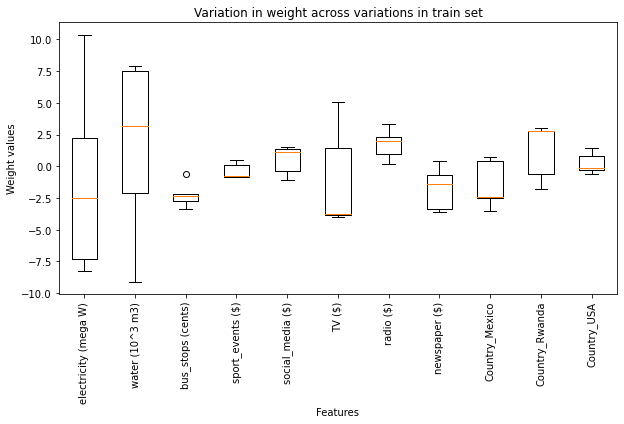

In [60]:
# Step 1: Uncomment and run
### we fit 5 regression models on 5 bootstrapped samples of our training data
# number of bootstrap samples to make
n_bootstrap = 5
# a list to store the weights of each regression model
bootstrap_weights = []
for n in range(n_bootstrap):
    # create new training data
    X_train, _, y_train, _ = split_data(X, y, seed=n)
    # train linear regressor model
    linear_regressor.fit(X_train,y_train)
    # save the regression weights
    bootstrap_weights.append(linear_regressor.coef_[0])
    
bootstrap_weights = np.array(bootstrap_weights)

# make a box plot for the regression weights
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_confidence_intervals(bootstrap_weights, ax)
plt.show()

#### Constructing the Predictive Interval of a Regression Model

In test data, company 30 is **Coca-cola** and company 29 is **Inyange**.

**Exercise 13:** Using your linear regression model predict which company will have a higher total sales based on their marketing strategy.

Construct the predictive interval for each predicted total sales. 

How confident are you in your predictions? Support your answers using concepts from lecture.

In [ ]:
X_test_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Nationality,Country_Mexico,Country_Rwanda,Country_USA
company 1,0.18311,0.979121,1027.52,26.3546,6.12187,89.5255,0.3,23.2,107,American,0,0,1
company 2,30.6507,32.1584,2412.87,49.8748,26.5837,165.87,7.8,35.2,177,Rwandan,0,1,0
company 3,1.89494,1.00387,3896.79,48.5626,47.3148,208.835,49.6,37.7,58,Rwandan,0,1,0
company 4,2.81545,2.47702,74.0314,41.3383,22.4982,290.077,27.7,1.8,42,Rwandan,0,1,0
company 5,2.33241,1.13286,1326.8,0.226549,NaN,241.719,49,44.3,147,Rwandan,0,1,0


In [61]:
# Step 1: predict on the test data
# COMPLETE
y_predict = linear_regressor.predict(X_df.values)

# Step 2: get the 29th and 30th predictions
# COMPLETE
y_pred_29 = y_predict[28]
y_pred_30 = y_predict[29]

# print the total sales of company 29 and company 30
print('Predicted sales for Coca-cola: %.2f (thousand units)' % y_pred_29)
print('Predicted sales for Inyange: %.2f (thousand units)' % y_pred_30)

Predicted sales for Coca-cola: 14.44 (thousand units)
Predicted sales for Inyange: 11.67 (thousand units)


Construct the predictive interval for each predicted total sales. Based on these intervals, how confident are you in your predictions?

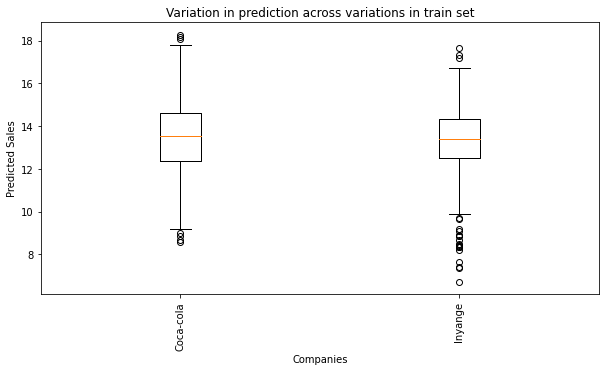

In [63]:
# Step 1: Uncommnent and run
### we fit 1000 regression models on 1000 bootstrapped samples of our training data
n_bootstrap = 1000
# make a list to store the predicted sales
bootstrap_y_pred = []
for n in range(n_bootstrap):
    # make new data
    X_train, _, y_train, _ = split_data(X, y, seed=n)
    # train linear regression model
    linear_regressor.fit(X_train,y_train)
    # predict on company 30 and 31
    y_predict = linear_regressor.predict(X_test[29:31])
    # add the prediction to the list
    bootstrap_y_pred.append(y_predict)
# convert the list into an array
bootstrap_y_pred = np.array(bootstrap_y_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_predictive_intervals(bootstrap_y_pred, ['Coca-cola', 'Inyange'], ax)
plt.show()